# 

# Combination of Two Machine Learning Models

1. [Libraries and Data Loading](#1)
2. [Statistics](#2)
3. [Feature Selection](#3)
4. [Feature Extration](#4)
5. [Processing Supervised model](#5)
6. [K-means Clustering and Artificail Neural Network](#6)
7. [Plots](#7)


## <a id="1">1. Libraries and Data Loading</a>
Pandas is managed to read the xlsx file and create two dataframes: one for traning and another for testing.<br>
All sheets from traning data are merged into one dataframe and then transformed to a spark dataframe.<br>
Similar, all sheets from test data are merged into one dataframe and then transformed to a spark dataframe.

In [103]:
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Dropout
from sklearn import svm
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA as skPCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import pandas as pandi
import matplotlib.pyplot as plt
import seaborn as seab
import plotly.express as ploti
import numpy as numpi
import warnings

pandi.set_option('display.width', 1500) #Increasing the display output width

In [2]:
warnings.filterwarnings('ignore')

# Loading XLSX file into Pandas to create one dataframe concatenating the sheets from Train-1 to Train-10
df_training = pandi.read_excel('./data/Project data set 1 (for reports 1 and 3) .xlsx', sheet_name=['Train-1', 'Train-2', 'Train-3', 'Train-4', 'Train-5', 'Train-6', 'Train-7', 'Train-8', 'Train-9', 'Train-10'])
df_training = pandi.concat(df_training.values(), ignore_index=True)

# Loading XLSX file into Pandas with the sheets from Test-1 to Test-5
df_testing = pandi.read_excel('./data/Project data set 1 (for reports 1 and 3) .xlsx', sheet_name=['Test-1', 'Test-2', 'Test-3', 'Test-4', 'Test-5'])
# df_testing = pandi.concat(df_testing.values(), ignore_index=True)

# Printing Columns
print('\nColumn names:\n')
print(df_training.columns.tolist())
print(df_training.head(2))
print(f'Training dataset shape: {df_training.shape}')
print(f'Testing dataset shape: {df_testing["Test-1"].shape}')


Column names:

['BIS', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
    BIS        x1        x2        x3        x4        x5        x6        x7  \
0  90.2  0.689160  3.643863  1.789239  1.778735  0.656469  0.385934  1.031026   
1  90.2  0.704845  3.636994  1.780926  1.778575  0.661085  0.388855  1.031065   

         x8  
0  1.790311  
1  1.790393  
Training dataset shape: (27452, 9)
Testing dataset shape: (2905, 9)


## <a id="2">2. Statistics</a>

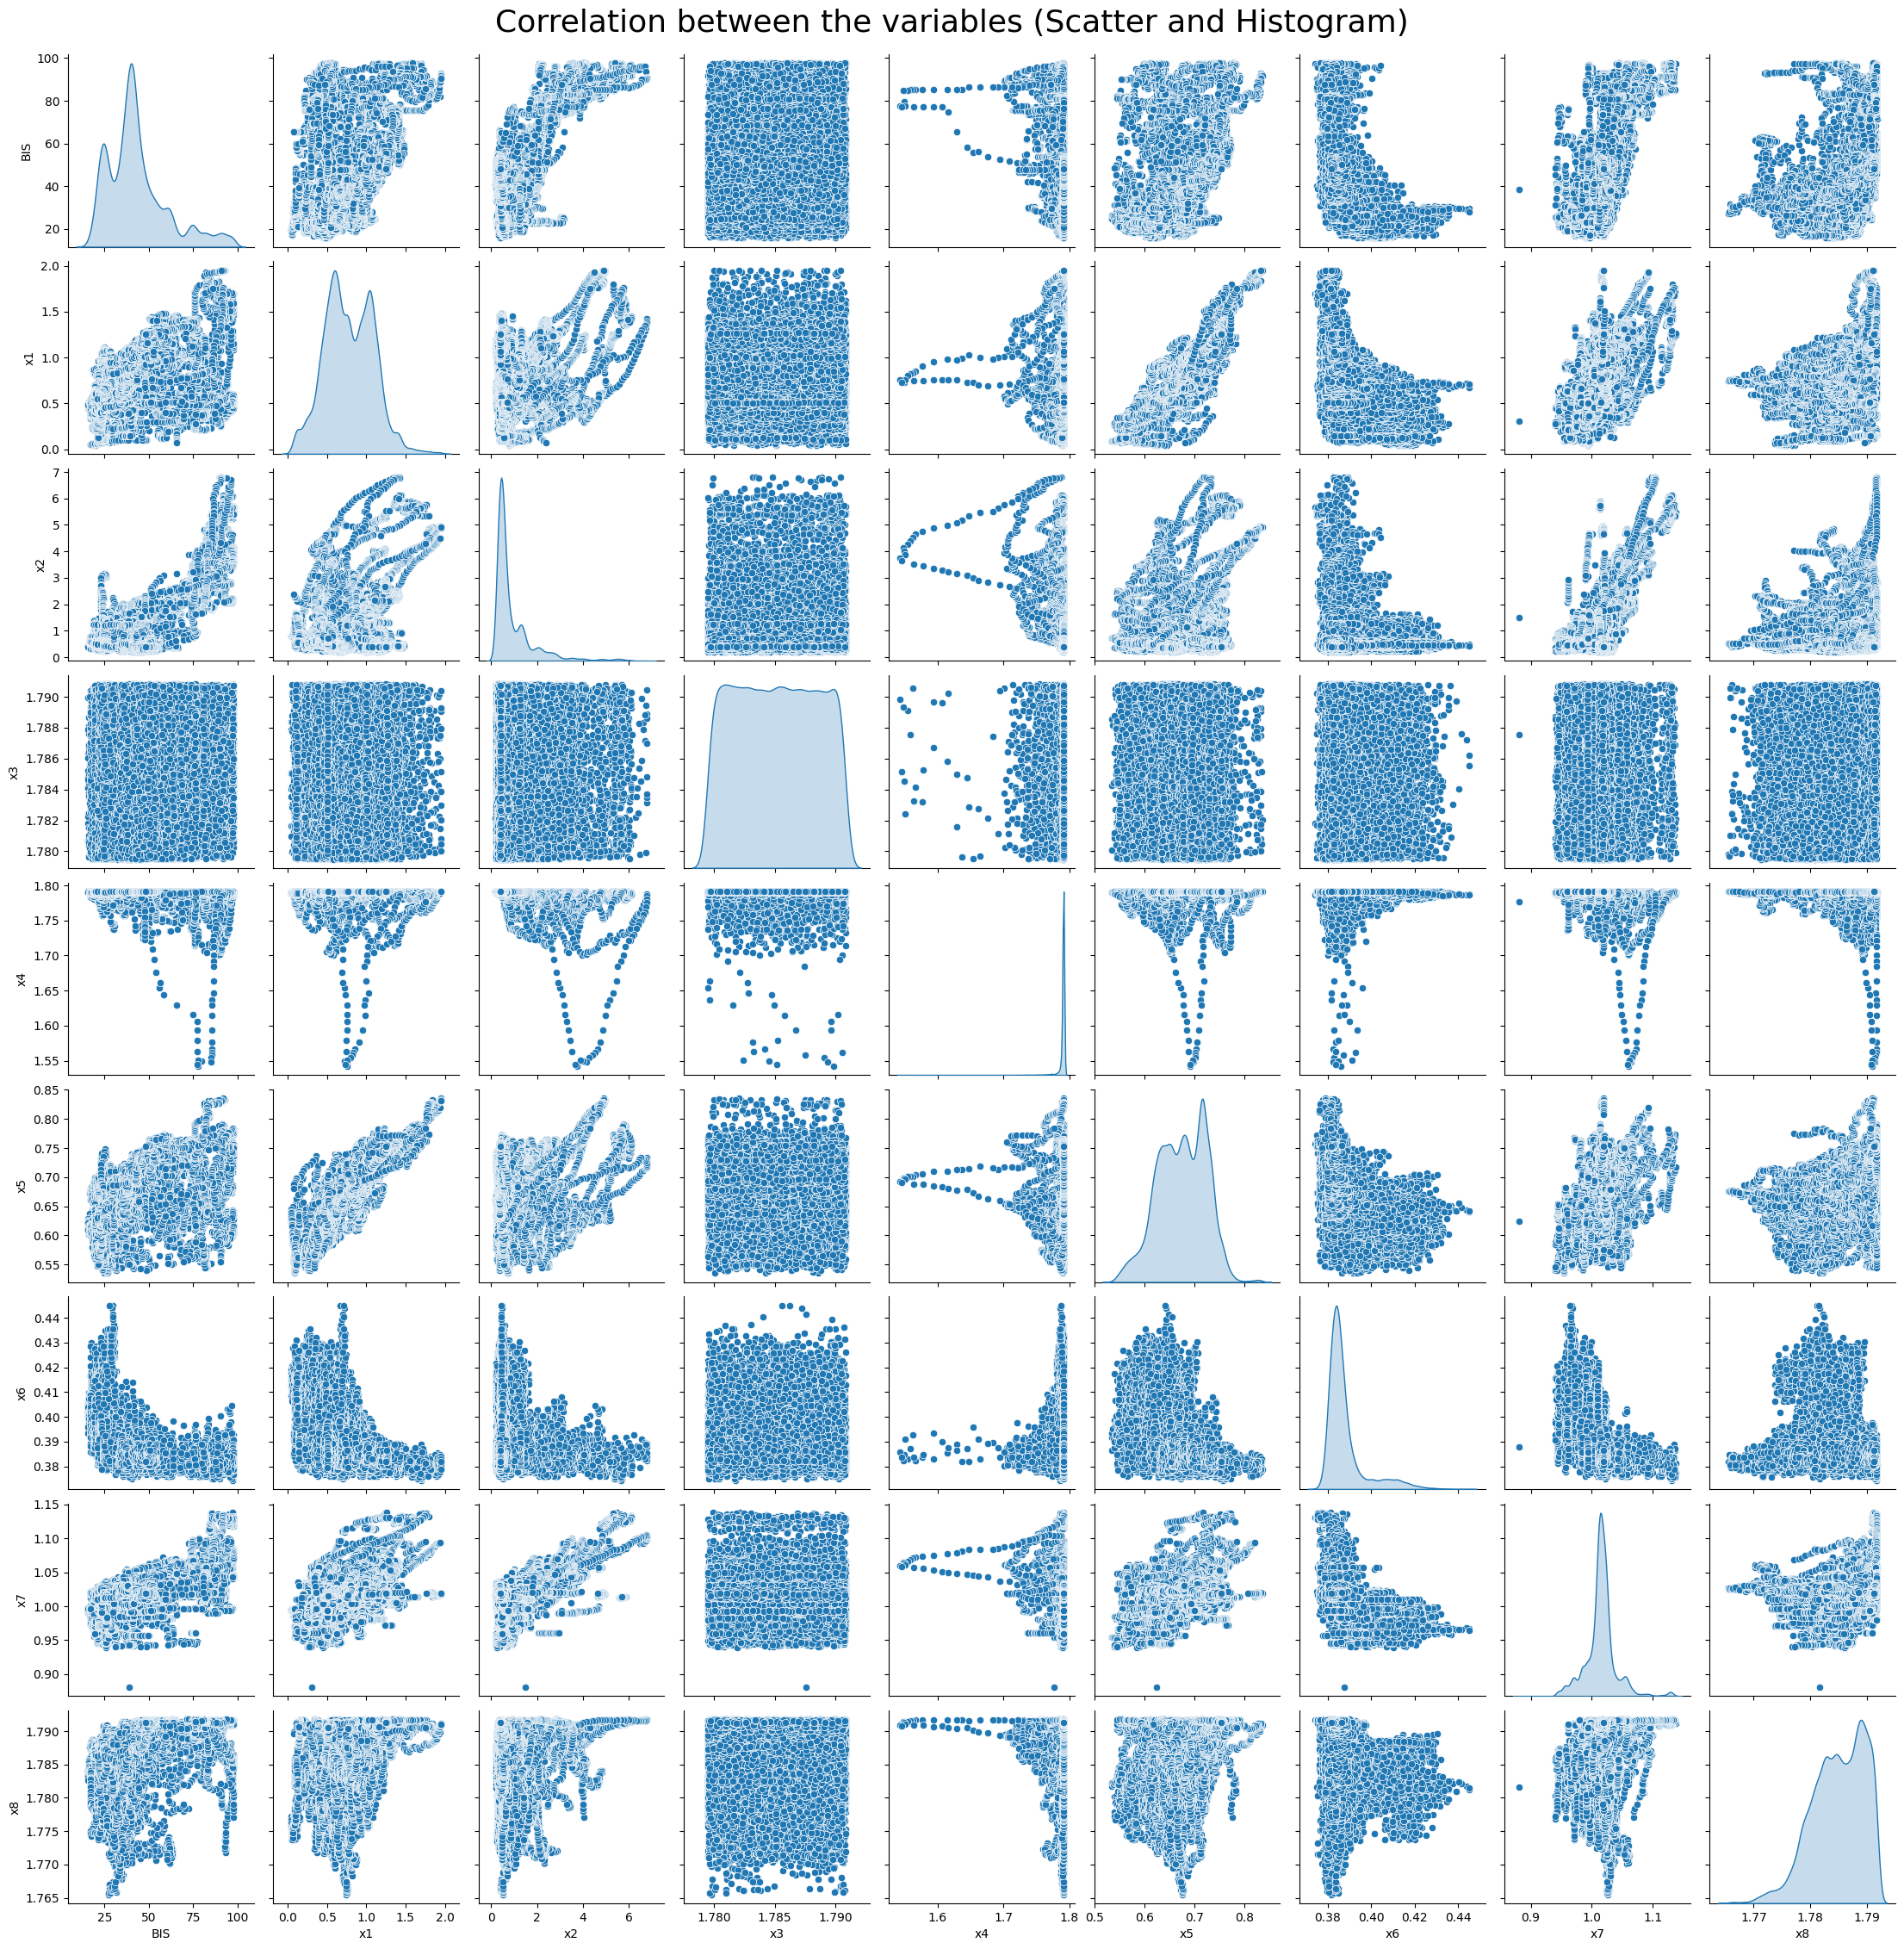

       BIS     x1     x2     x3     x4     x5     x6     x7     x8
BIS  1.000  0.474  0.744  0.008 -0.233  0.458 -0.490  0.643  0.451
x1   0.474  1.000  0.255  0.005  0.035  0.902 -0.475  0.469  0.342
x2   0.744  0.255  1.000  0.011 -0.330  0.190 -0.174  0.608  0.284
x3   0.008  0.005  0.011  1.000 -0.006  0.007  0.002  0.009  0.011
x4  -0.233  0.035 -0.330 -0.006  1.000  0.038  0.005 -0.130 -0.095
x5   0.458  0.902  0.190  0.007  0.038  1.000 -0.469  0.420  0.340
x6  -0.490 -0.475 -0.174  0.002  0.005 -0.469  1.000 -0.539 -0.116
x7   0.643  0.469  0.608  0.009 -0.130  0.420 -0.539  1.000  0.173
x8   0.451  0.342  0.284  0.011 -0.095  0.340 -0.116  0.173  1.000


In [3]:
## Generating basic statistics
df_training.drop('BIS', axis=1).describe().round(3)

# Visual correlation between variables using parplot from seaborn
seab.pairplot(df_training, diag_kind='kde')
plt.suptitle('Correlation between the variables (Scatter and Histogram)', fontsize=26, y=1.01)
plt.show()

## Generating the Correlation Matrix (Pearson Coefficient)
personCorrM = df_training.corr(method='pearson').round(3)
print(personCorrM)

heatmap_mask = numpi.triu(numpi.ones_like(df_training.corr(method='pearson'), dtype=bool))
heatmap_mask_cm = personCorrM.mask(heatmap_mask)

ploti_fig = ploti.imshow(heatmap_mask_cm,
                        color_continuous_scale='rdylgn',
                        text_auto=True,
                        width=700, height=700,
                        zmin=-1, zmax=1,
                        title='Correlation Matrix')
ploti_fig.show()


## <a id="3">3. Feature Selection</a>

In [4]:
## Feature Selection using Correlation Matrix (Pearson Coefficient)
# Selecting the features with correlation coefficient higher than 0.5
corr_threshold = 0.5
df_training_corr = personCorrM.drop('BIS', axis=0).drop('BIS', axis=1)
df_training_corr = df_training_corr[df_training_corr > corr_threshold].dropna(axis=0, how='all').dropna(axis=1, how='all').mask(df_training_corr == 1.0)
df_training_corr = df_training_corr.stack().reset_index()
df_training_corr.columns = ['Features 1', 'Features 2', 'Correlation Coefficient']
print('\nFeatures selected by the Correlation Matrix:\n')
print(df_training_corr)



## Univariate Feature Selection
# Before applying the Univariate Feature Selection, we need to discretise the target variable (BIS)
# So, the target variable (BIS) is discretised into 5000 bins
discretiser = KBinsDiscretizer(n_bins=27452, encode='ordinal', strategy='uniform')
df_training_discretised = discretiser.fit_transform(df_training['BIS'].values.reshape(-1, 1))
df_training_discretised = df_training_discretised.ravel()

# Select the top 4 features with the highest ChiSqSelector score
selectkbest = SelectKBest(score_func=chi2, k=4)
selectkbest.fit(df_training.drop('BIS', axis=1), df_training_discretised)
df_training_univ = selectkbest.transform(df_training.drop('BIS', axis=1))
df_training_univ_names = df_training.drop('BIS', axis=1).columns.values[selectkbest.get_support()]
df_training_univ_fs = pandi.DataFrame(df_training_univ, columns=df_training_univ_names)
print('\nFeatures selected by using Univariate :\n')
print(df_training_univ_fs.head(2))
df_training_univ_fs_col = df_training_univ_fs.columns
print(df_training_univ_fs_col.tolist())



Features selected by the Correlation Matrix:

  Features 1 Features 2  Correlation Coefficient
0         x1         x5                    0.902
1         x2         x7                    0.608
2         x5         x1                    0.902
3         x7         x2                    0.608

Features selected by using Univariate :

         x1        x2        x5        x7
0  0.689160  3.643863  0.656469  1.031026
1  0.704845  3.636994  0.661085  1.031065
['x1', 'x2', 'x5', 'x7']


## <a id="4">4. Feature Extration</a>

In [67]:
test_datasets = ['Test-1', 'Test-2', 'Test-3', 'Test-4', 'Test-5']

## Independent Component Analysis ICA from Sklearn
# Training dataset from ICA features
ica_array_features = []
for n_components in range(2, 9):
    ica = FastICA(n_components=n_components, random_state=0)
    ica = ica.fit(df_training.drop('BIS', axis=1))

    ica_array_features.append(pandi.DataFrame(ica.transform(df_training.drop('BIS', axis=1)), columns=ica.get_feature_names_out().tolist()))
    print(f'ICA - Training Features with {n_components} components:\n{ica_array_features[n_components - 2].columns.tolist()}\n')

# Testing dataset from ICA features
# the object ica_array_features_test is an object that contains the features from the testing dataset
# It is organised as a dictionary with the key as the name of the test dataset and the value as the features
# But every test dataset has different number of features, so the key is the name of the test dataset and the number of components
# Example: Test-1_2 means that the test dataset is Test-1 and the number of components is 2
# Test-1_3 means that the test dataset is Test-1 and the number of components is 3
# and so on...
ica_array_features_test = {}
for idx, test in enumerate(test_datasets):
    for n_components in range(2, 9):
        ica = FastICA(n_components=n_components, random_state=0)
        ica = ica.fit(df_testing[test].drop('BIS', axis=1))
        ica_array_features_test[f'{test}_{n_components}'] = pandi.DataFrame(ica.transform(df_testing[test].drop('BIS', axis=1)), columns=ica.get_feature_names_out().tolist())
        columns = ica_array_features_test[f'{test}_{n_components}'].columns.tolist()
        print(f'ICA - Testing Features for {test} components {n_components}:\n{columns}\n')

## Principal Component Analysis PCA from Sklearn
# Training dataset from PCA features
pca_array_features = []
for n_components in range(2, 9):
    pca = skPCA(n_components=n_components)
    pca = pca.fit(df_training.drop('BIS', axis=1))
    pca_array_features.append(pandi.DataFrame(pca.transform(df_training.drop('BIS', axis=1)), columns=pca.get_feature_names_out().tolist()))
    print(f'PCA - Training Features with {n_components} components:\n{pca_array_features[n_components - 2].columns.tolist()}\n')

# Testing dataset from PCA features
# the object pca_array_features_test is an object that contains the features from the testing dataset
# It is organised as a dictionary with the key as the name of the test dataset and the value as the features
# But every test dataset has different number of features, so the key is the name of the test dataset and the number of components
# Example: Test-1_2 means that the test dataset is Test-1 and the number of components is 2
# Test-1_3 means that the test dataset is Test-1 and the number of components is 3
# and so on...
pca_array_features_test = {}
for idx, test in enumerate(test_datasets):
    for n_components in range(2, 9):
        pca = skPCA(n_components=n_components)
        pca = pca.fit(df_testing[test].drop('BIS', axis=1))
        pca_array_features_test[f'{test}_{n_components}'] = pandi.DataFrame(pca.transform(df_testing[test].drop('BIS', axis=1)), columns=pca.get_feature_names_out().tolist())
        columns = pca_array_features_test[f'{test}_{n_components}'].columns.tolist()
        print(f'PCA - Testing Features for {test} components {n_components}:\n{columns}\n')

    

ICA - Training Features with 2 components:
['fastica0', 'fastica1']

ICA - Training Features with 3 components:
['fastica0', 'fastica1', 'fastica2']

ICA - Training Features with 4 components:
['fastica0', 'fastica1', 'fastica2', 'fastica3']

ICA - Training Features with 5 components:
['fastica0', 'fastica1', 'fastica2', 'fastica3', 'fastica4']

ICA - Training Features with 6 components:
['fastica0', 'fastica1', 'fastica2', 'fastica3', 'fastica4', 'fastica5']

ICA - Training Features with 7 components:
['fastica0', 'fastica1', 'fastica2', 'fastica3', 'fastica4', 'fastica5', 'fastica6']

ICA - Training Features with 8 components:
['fastica0', 'fastica1', 'fastica2', 'fastica3', 'fastica4', 'fastica5', 'fastica6', 'fastica7']

ICA - Testing Features for Test-1 components 2:
['fastica0', 'fastica1']

ICA - Testing Features for Test-1 components 3:
['fastica0', 'fastica1', 'fastica2']

ICA - Testing Features for Test-1 components 4:
['fastica0', 'fastica1', 'fastica2', 'fastica3']

ICA - T

# <a id="5">5. Processing the models: ANN -> SVM</a>

In [112]:

## Artificail Neural Network ANN
# Creating the ANN model

# train_labels = df_training['BIS']
# test_features = df_testing['Test-1'].drop('BIS', axis=1)[df_training_univ_fs_col]
def combined_ML(test, train_features, test_features, train_labels, test_labels, method, number_first_h_layer):

    data_analysis = pandi.DataFrame(columns=['Test', 'Method', 'Features', 'ANN_first_h_layer', 'ANN_second_h_layer', 'Pearson', 'MSE', 'MAE', 'R2', 'number_first_h_layer'])

    dimention_input = train_features.shape[1]

    second_h_layer = dimention_input

    # This variable will help to skip the whole process of looking for the best features by
    # checking the pearson coefficient less than 8.0. 
    # If it is less than 8.0 after the first "for" loop, the whole searching is skipped to the features.
    coef = -1

    # Checking the number of neurons in the first hidden layer
    # If the number is None, the number of neurons in the first hidden layer is 18. It'll start to look for the best number of neurons in the first hidden layer
    # If the number is less than 2 or greater than 18, it'll raise an error
    # If the number is between 2 and 18, it will process the features ones to train the Model
    mode_analysis = 'best hidden layer'
    if number_first_h_layer == None:
        number_first_h_layer = 18
    elif number_first_h_layer < 2 or number_first_h_layer > 18:
        raise ValueError('The number of neurons in the first hidden layer must be between 2 and 18')
    else:
        second_h_layer = number_first_h_layer
        mode_analysis = 'best features'

    for first_h_layer in range(second_h_layer, number_first_h_layer + 1):

        ann_model = Sequential()
        ann_model.add(Dense(first_h_layer, input_dim=dimention_input, activation='tanh'))
        ann_model.add(Dense(second_h_layer, activation='tanh'))
        ann_model.add(Dense(1, activation='linear'))

        # Compiling the ANN model
        ann_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

        # Fitting the ANN model
        ann_model.fit(train_features, train_labels, epochs=35, batch_size=10, verbose=0)

        # Extracting the new train_features for the SVM from the hidden layers
        hidden_layers = ann_model.layers[1:-1]
        features_hidden_layer_model = Model(inputs=ann_model.input, outputs=[ly.output for ly in hidden_layers])

        # Predicting with the hidden layers to use the results as train_features for the SVM
        features_hidden_layer = features_hidden_layer_model.predict(train_features)

        ## TRAINING THE SVM MODEL
        # Connect the new model to SVM
        svm_model = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
        svm_model.fit(features_hidden_layer, train_labels)

        ## TESTING THE SVM MODEL
        # Predicting first with the ANN model
        features_hidden_layer = features_hidden_layer_model.predict(test_features)
        # Predicting with the SVM model
        pd_svm = pandi.DataFrame(svm_model.predict(features_hidden_layer), columns=['newBIS'])
        # statistics
        coef, pv = pearsonr(test_labels.ravel(), pd_svm['newBIS'].ravel())
        new_row = {'Test': test,
                    'Method': method, 
                    'Features': train_features.columns.tolist(), 
                    'ANN_first_h_layer': first_h_layer, 
                    'ANN_second_h_layer': second_h_layer, 
                    'Pearson': coef, 
                    'MSE': mean_squared_error(test_labels, pd_svm['newBIS']),
                    'MAE': mean_absolute_error(test_labels, pd_svm['newBIS']),
                    'R2': r2_score(test_labels, pd_svm['newBIS']),
                    'number_first_h_layer': first_h_layer,
                    }
        
        data_analysis = pandi.concat([data_analysis, pandi.DataFrame(new_row)], ignore_index=True)
        print(new_row)
        print(data_analysis)
        print('Max pearson', data_analysis['Pearson'].max())
        print(data_analysis.loc[data_analysis['Pearson'] == data_analysis['Pearson'].max(), 'number_first_h_layer'])

        # if coef less than 8.3 skip whole process for this features to try the next ones
        if (coef < 8.5 and coef != -1) and (first_h_layer == second_h_layer) or (mode_analysis == 'best hidden layer'):
            break
        
        # plot predictions and expected results
        # plt.plot(test_labels, label='Expected')
        # plt.plot(pd_svm['newBIS'], label='Predicted')
        # plt.legend()
        # plt.show()
    
    number_first_h_layer = data_analysis[data_analysis['Pearson'] == data_analysis['Pearson'].max()].at[0, 'number_first_h_layer']
    
    return data_analysis.drop('number_first_h_layer', axis=1), number_first_h_layer, data_analysis['Pearson'].max()


### Processing the combined model: ANN -> SVM using the different features

In [113]:
# ## Uivariate Feature Selection
test_datasets = ['Test-1', 'Test-2', 'Test-3', 'Test-4', 'Test-5']

# data_analysis_univ = pandi.DataFrame(columns=['Test', 'Method', 'Features', 'ANN_first_h_layer', 'ANN_second_h_layer', 'Pearson', 'MSE', 'MAE', 'R2'])
# for test in test_datasets:
#     stat_comb_ml = combined_ML(test, df_training_univ_fs, df_testing[test].drop('BIS', axis=1)[df_training_univ_fs_col], df_training['BIS'], df_testing[test]['BIS'], 'Univariate')
#     data_analysis_univ = pandi.concat([data_analysis_univ, stat_comb_ml], ignore_index=True)

# display(data_analysis_univ.to_string())
# data_analysis_univ.to_excel(f'./data/data_analysis_univ.xlsx', index=False)

## Looking for the best layer for the ANN using ICA features
# Using Test-5 dataset to find the best layer for the ANN as its result is the best
best_h_layer = pandi.DataFrame(columns=['features', 'layers', 'coeff'])
# for index_test, test in enumerate(test_datasets):
for index_features, ica_features in enumerate(ica_array_features):
    columns = ica_array_features_test[f'Test-5_{index_features + 2}'].columns.tolist()
    print(f'index: {index_features} - test: Test-5 - columns of feature test: {columns}')
    stat_comb_ml = combined_ML('Test-5', ica_features, ica_array_features_test[f'Test-5_{index_features + 2}'], df_training['BIS'], df_testing['Test-5']['BIS'], 'ICA', None)
    
    best_h_layer = pandi.concat([best_h_layer, pandi.DataFrame({
                                                                'features': [index_features + 2],
                                                                'layers': [stat_comb_ml[1]],
                                                                'coeff': [stat_comb_ml[2]]
                                                            })], ignore_index=True)

best_h_layer_features = best_h_layer['coeff' == best_h_layer['coeff'].max()].at[0, 'features']
best_h_layer_ica = best_h_layer['coeff' == best_h_layer['coeff'].max()].at[0, 'layers']
best_h_layer_coeff = best_h_layer['coeff' == best_h_layer['coeff'].max()].at[0, 'coeff']
print(f'Best number of neurons in the first hidden layer: {best_h_layer}\nBest number of features: {best_h_layer_features}\nBest Pearson Coefficient: {best_h_layer_coeff}')
# save
best_h_layer.to_excel(f'./data/best_h_layer_ICA.xlsx', index=False)

## ICA Feature Selection
data_analysis_ica = pandi.DataFrame(columns=['Test', 'Method', 'Features', 'ANN_first_h_layer', 'ANN_second_h_layer', 'Pearson', 'MSE', 'MAE', 'R2'])
for index_test, test in enumerate(test_datasets):
    for index_features, ica_features in enumerate(ica_array_features):
        columns = ica_array_features_test[f'{test}_{index_features + 2}'].columns.tolist()
        print(f'index: {index_features} - test: {test} - columns of feature test: {columns}')
        stat_comb_ml = combined_ML(test, ica_features, ica_array_features_test[f'{test}_{index_features + 2}'], df_training['BIS'], df_testing[test]['BIS'], 'ICA', best_h_layer_ica)
        result_ica = pandi.concat([data_analysis_ica, result_ica[0]], ignore_index=True)

display(data_analysis_ica.to_string())
data_analysis_ica.to_excel(f'./data/data_analysis_ica.xlsx', index=False)


## Looking for the best layer for the ANN using PCA features
# Using Test-5 dataset to find the best layer for the ANN as its result is the best
best_h_layer = pandi.DataFrame(columns=['features', 'layers', 'coeff'])
# for index_test, test in enumerate(test_datasets):
for index_features, pca_features in enumerate(pca_array_features):
    columns = pca_array_features_test[f'Test-5_{index_features + 2}'].columns.tolist()
    print(f'index: {index_features} - test: Test-5 - columns of feature test: {columns}')
    stat_comb_ml = combined_ML('Test-5', pca_features, pca_array_features_test[f'Test-5_{index_features + 2}'], df_training['BIS'], df_testing['Test-5']['BIS'], 'PCA', None)
    
    best_h_layer = pandi.concat([best_h_layer, pandi.DataFrame({
                                                                'features': [index_features + 2],
                                                                'layers': [stat_comb_ml[1]],
                                                                'coeff': [stat_comb_ml[2]]
                                                            })], ignore_index=True)
    
best_h_layer_features = best_h_layer['coeff' == best_h_layer['coeff'].max()].at[0, 'features']
best_h_layer_pca = best_h_layer['coeff' == best_h_layer['coeff'].max()].at[0, 'layers']
best_h_layer_coeff = best_h_layer['coeff' == best_h_layer['coeff'].max()].at[0, 'coeff']
print(f'Best number of neurons in the first hidden layer: {best_h_layer}\nBest number of features: {best_h_layer_features}\nBest Pearson Coefficient: {best_h_layer_coeff}')
# save
best_h_layer.to_excel(f'./data/best_h_layer_PCA.xlsx', index=False)

## PCA Feature Selection
data_analysis_pca = pandi.DataFrame(columns=['Test', 'Method', 'Features', 'ANN_first_h_layer', 'ANN_second_h_layer', 'Pearson', 'MSE', 'MAE', 'R2'])
for index_test, test in enumerate(test_datasets):
    for index_features, pca_features in enumerate(pca_array_features):
        columns = pca_array_features_test[f'{test}_{index_features + 2}'].columns.tolist()
        print(f'index: {index_features} - test: {test} - columns of feature test: {columns}')
        stat_comb_ml = combined_ML(test, pca_features, pca_array_features_test[f'{test}_{index_features + 2}'], df_training['BIS'], df_testing[test]['BIS'], 'PCA', best_h_layer_pca)
        result_pca = pandi.concat([data_analysis_pca, result_pca[0]], ignore_index=True)

display(data_analysis_pca.to_string())
data_analysis_pca.to_excel(f'./data/data_analysis_pca.xlsx', index=False)


index: 0 - test: Test-5 - columns of feature test: ['fastica0', 'fastica1']
88/88 [==============================] - 0s 1ms/step
{'Test': 'Test-5', 'Method': 'ICA', 'Features': ['fastica0', 'fastica1'], 'ANN_first_h_layer': 2, 'ANN_second_h_layer': 2, 'Pearson': -0.16865389917201484, 'MSE': 522.6820405398403, 'MAE': 17.8357427414071, 'R2': -0.5143161210573115, 'number_first_h_layer': 2}
     Test Method  Features ANN_first_h_layer ANN_second_h_layer   Pearson         MSE        MAE        R2 number_first_h_layer
0  Test-5    ICA  fastica0                 2                  2 -0.168654  522.682041  17.835743 -0.514316                    2
1  Test-5    ICA  fastica1                 2                  2 -0.168654  522.682041  17.835743 -0.514316                    2
Max pearson -0.16865389917201484


KeyError: 'number_frist_h_layer'

### PLotings

91/91 [==============================] - 0s 2ms/step


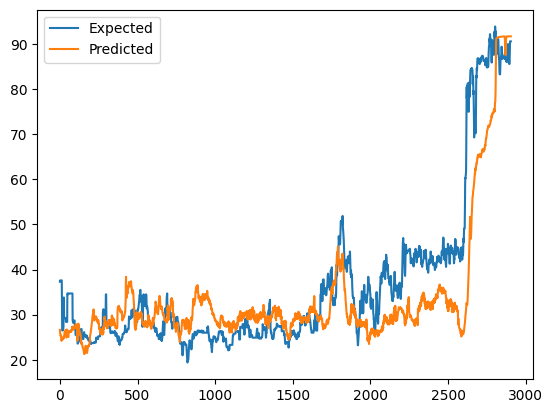

In [59]:

# plot predictions and expected results
plt.plot(df_testing['Test-1']['BIS'], label='Expected')
plt.plot(ann_model.predict(df_testing['Test-1'].drop('BIS', axis=1)[df_training_univ_fs_col]), label='Predicted')
plt.legend()
plt.show()


In [64]:
# Extracting the features from the hidden layers
print(ann_model.summary())
hidden_layers = ann_model.layers[1:-1]
# print(len(hidden_layers))

features_hidden_layer_model = Model(inputs=ann_model.input, outputs=[ly.output for ly in hidden_layers])
print(features_hidden_layer_model.summary())

# predicting the features from the hidden layers
features_hidden_layer = features_hidden_layer_model.predict(df_training_univ_fs)
print(features_hidden_layer)

## TRAINING THE SVM MODEL
# Connect the new model to SVM
svm_model = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
svm_model.fit(features_hidden_layer, df_training['BIS'])
svm_model.score(features_hidden_layer, df_training['BIS'])
svm_model.predict(features_hidden_layer)





Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 8)                 40        
                                                                 
 dense_43 (Dense)            (None, 2)                 18        
                                                                 
 dense_44 (Dense)            (None, 1)                 3         
                                                                 
Total params: 61 (244.00 Byte)
Trainable params: 61 (244.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42_input (InputLayer  [(None, 4)]               0         
 )                                                          

0.7901191266567356

 1/91 [..............................] - ETA: 1s

91/91 [==============================] - 0s 1ms/step


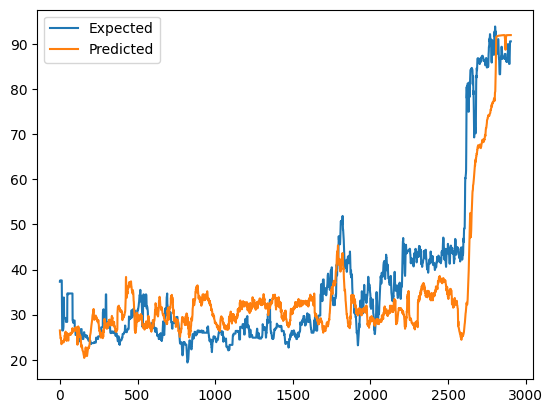

In [65]:
## TESTING THE SVM MODEL
features_hidden_layer = features_hidden_layer_model.predict(df_testing['Test-1'].drop('BIS', axis=1)[df_training_univ_fs_col])

# plot predictions and expected results
plt.plot(df_testing['Test-1']['BIS'], label='Expected')
plt.plot(svm_model.predict(features_hidden_layer), label='Predicted')
plt.legend()
plt.show()
